<h1 align="center"> <span style="font-size: 20px;"> Proyecto Final Grupo Nº 7 </span> <br>
    <align="center"> <span style="font-size: 15px;">  Proyecto Yelp & Google Maps - Reviewa y Recomendaciones</span><br>         
<align="center"> <span style="font-size: 15px;">@utores:  Javier Castro, Luca Ramallo, Luis Ramírez, Lesmen García.</span> <br>
  <a href="https://github.com/lesmengp/Proyecto-Final-Grupo-07.git">GitHub: <span style="font-size: 20px;">Proyecto Yelp & Google Maps</span></a> 
</h1>

# Análisis de sentimientos con BERT


### Librerías a Utilizar:

In [1]:
!pip install transformers

In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install Dataset

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install DataLoader

Note: you may need to restart the kernel to use updated packages.


In [5]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from google.cloud import storage
import os

In [6]:
# Google Cloud Platform
# Obtener el proyecto actual
project_id = os.environ.get("Proyecto Final - Henry")

# Crear un cliente de Cloud Storage
client = storage.Client(project=project_id)

# Obtener el nombre del bucket
bucket_name = "gmy"

# Obtener el objeto de referencia al bucket
bucket = client.bucket(bucket_name)

### Definición de Funciones

### Cargando Dataset Yelp Reviews: 'yelp_reviews.parquet'

In [7]:
### Cargando DataSets Consolidado para Análisis de ML: 'yelp_reviews.parquet'
# Ruta completa en Cloud Storage
ruta_eda_datalike = "gs://gmy/etl/yelp_reviews.parquet"

# Lee el archivo Parquet directamente en un DataFrame de pandas
df_ML_promedios = pd.read_parquet(ruta_eda_datalike, storage_options={"project": "Proyecto Final - Henry"})
df_ML_promedios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742210 entries, 0 to 2742209
Data columns (total 8 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_id    object
 1   user_id      object
 2   business_id  object
 3   stars        int64 
 4   useful       int64 
 5   cool         int64 
 6   text         object
 7   date         object
dtypes: int64(3), object(5)
memory usage: 167.4+ MB


In [8]:
df_ML_promedios.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'cool',
       'text', 'date'],
      dtype='object')

In [9]:
df_ML_promedios

,review_id,user_id,business_id,stars,useful,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,"If you decide to eat here, just be aware it is...",2018-07-07
1,lUUhg8ltDsUZ9h0xnwY4Dg,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4,1,1,I was really between 3 and 4 stars for this on...,2018-07-17
2,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23
3,E9AB7V4z8xrt2uPF7T55FQ,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27
4,A4n4YaE-owOVgTQcrVqHUw,S7bjj-L07JuRr-tpX1UZLw,I6L0Zxi5Ww0zEWSAVgngeQ,4,0,0,The cafe was extremely cute. We came at 8am an...,2018-07-07
...,...,...,...,...,...,...,...,...
2742205,9GZNb8FS9sUpihQUE3T1Gw,GzWKptKPmgoWVhct2mScKA,Edi-puimcDi8yeebE9E1uQ,1,0,0,I've stayed here before and had no issues with...,2019-07-05
2742206,M3sghmzkenwlHkmwbPf-qw,kvyAIhIifrxKDXExNjYQEQ,9EoNx6yHsmiCe43XscJzDA,5,0,0,This was my first time here and omg it was ama...,2019-06-14
2742207,nu6GffU0Ip6z_YqfFffRQw,coSWqMIFx77eF5WY2IRI6g,vWjME92WddneF98IqzaNfQ,5,0,0,The service was great the food was fantastic t...,2019-05-31
2742208,sRZ06SW1ROkM3vH1jBluzQ,KyaXlfvE2LSW6pwWubNL0A,B6VXTY7VZVWQ8cbfPlH-vg,5,1,0,"Great food, great people, local bar with stron...",2019-06-13


In [10]:
# Trabajo con 4 columnas
df_ML_promedios = df_ML_promedios[['stars', 'useful', 'cool', 'text']]
df_ML_promedios = df_ML_promedios[df_ML_promedios['text'].notna()]
df_ML_promedios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742210 entries, 0 to 2742209
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   stars   int64 
 1   useful  int64 
 2   cool    int64 
 3   text    object
dtypes: int64(3), object(1)
memory usage: 83.7+ MB


In [11]:
df_ML_promedios.describe()

,stars,useful,cool
count,2.742210e+06,2.742210e+06,2.742210e+06
mean,3.761334e+00,9.466474e-01,4.795173e-01
std,1.560722e+00,2.944566e+00,2.376389e+00
min,1.000000e+00,-1.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00
max,5.000000e+00,5.390000e+02,2.070000e+02


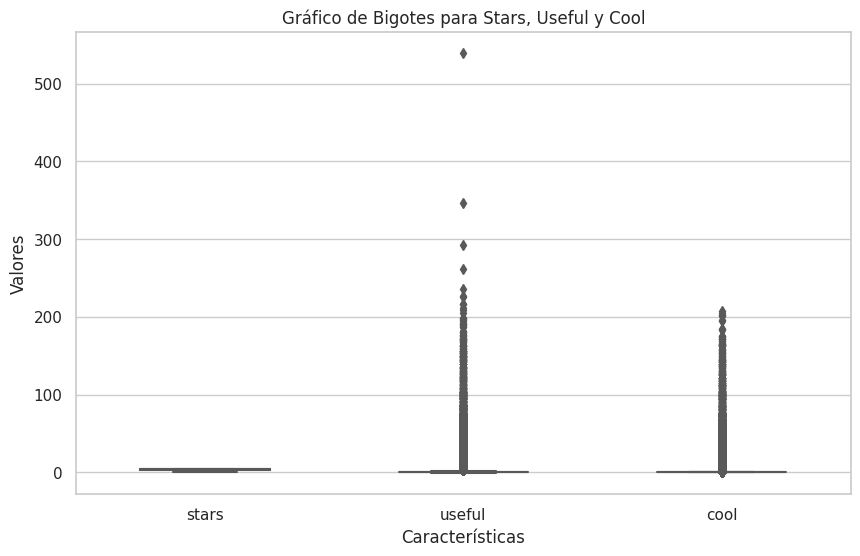

In [12]:
# Crear un gráfico de bigotes
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Estilo del gráfico

# Dibuja los bigotes
sns.boxplot(df_ML_promedios[['stars', 'useful', 'cool']], orient="v", width=0.5, palette="Set2")
plt.title('Gráfico de Bigotes para Stars, Useful y Cool')
plt.ylabel('Valores')
plt.xlabel('Características')
plt.show()


In [13]:
# Eliminando outliars
df_ML_promedios = df_ML_promedios[df_ML_promedios['useful'] <= 1]
df_ML_promedios = df_ML_promedios[df_ML_promedios['cool'] <= 1]

df_ML_promedios = df_ML_promedios[df_ML_promedios['useful'] >= 0]
df_ML_promedios = df_ML_promedios[df_ML_promedios['cool'] >= 0]

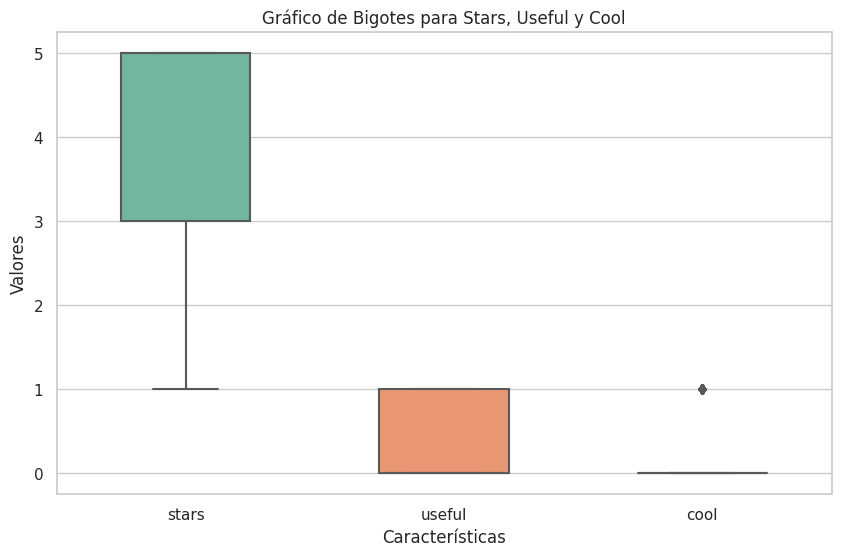

In [14]:
# Crear un gráfico de bigotes
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Estilo del gráfico

# Dibuja los bigotes
sns.boxplot(df_ML_promedios[['stars', 'useful', 'cool']], orient="v", width=0.5, palette="Set2")
plt.title('Gráfico de Bigotes para Stars, Useful y Cool')
plt.ylabel('Valores')
plt.xlabel('Características')
plt.show()

In [15]:
df_ML_promedios.describe()

,stars,useful,cool
count,2.231363e+06,2.231363e+06,2.231363e+06
mean,3.812853e+00,2.513401e-01,1.131775e-01
std,1.546032e+00,4.337837e-01,3.168097e-01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00
max,5.000000e+00,1.000000e+00,1.000000e+00


### Descartamos useful cool porque la mayoria son ceros

In [16]:
df_ML_promedios = df_ML_promedios[['stars', 'text']]
df_ML_promedios.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2231363 entries, 0 to 2742209
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   stars   int64 
 1   text    object
dtypes: int64(1), object(1)
memory usage: 51.1+ MB


In [17]:
df_ML_promedios.describe()

,stars
count,2.231363e+06
mean,3.812853e+00
std,1.546032e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


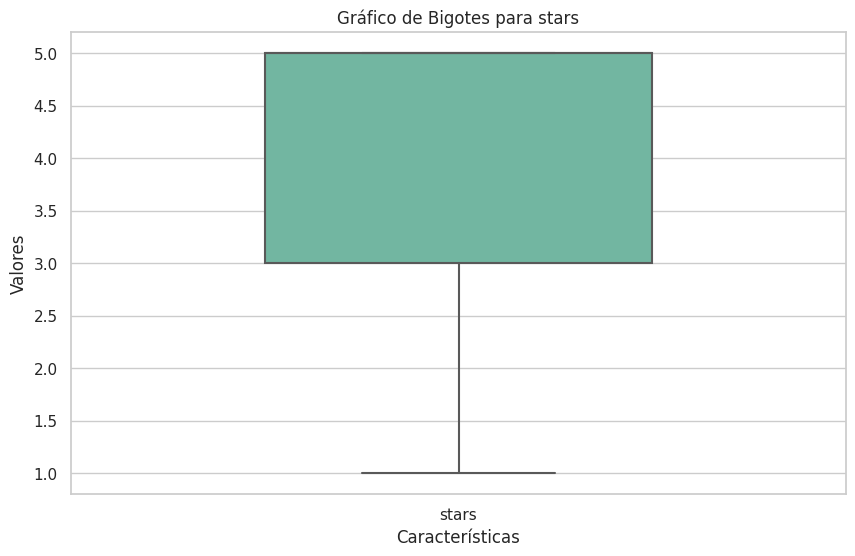

In [18]:
# Crear un gráfico de bigotes
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Estilo del gráfico

# Dibuja los bigotes
sns.boxplot(df_ML_promedios[['stars']], orient="v", width=0.5, palette="Set2")
plt.title('Gráfico de Bigotes para stars')
plt.ylabel('Valores')
plt.xlabel('Características')
plt.show()

### Utilizamos la biblioteca scikit-learn para construir un clasificador de comentarios positivos y negativos basado en las estrellas

In [19]:
# Dividir los datos en características (X) y etiquetas (y)
# X = df_ML_promedios['text']
# y = df_ML_promedios['stars']

# Convertir la columna 'Stars' en etiquetas binarias (0 para negativo, 1 para positivo)
# y = (y == 5).astype(int)

# Dividir el conjunto de datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizar las reseñas utilizando CountVectorizer
# vectorizer = CountVectorizer()
# X_train = vectorizer.fit_transform(X_train)
# X_test = vectorizer.transform(X_test)

# Entrenar un modelo de Regresión Logística
# clf = LogisticRegression()
# clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
# y_pred = clf.predict(X_test)

# Calcular la precisión del modelo
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Precisión del modelo: {accuracy * 100:.2f}%')


In [20]:
# Realizar predicciones en todo el dataset
# all_reviews = vectorizer.transform(data['text'])
# data['predicted'] = clf.predict(all_reviews)

# Mapear los valores predichos a "positivo" o "negativo"
# data['sentiment'] = data['predicted'].map({0: 'negativo', 1: 'positivo'})

In [21]:
# Agregar una nueva columna 'sentiment' basada en 'stars'
df_ML_promedios['sentiment'] = df_ML_promedios['stars'].apply(lambda x: 1 if x >= 3 else 0)
df_ML_promedios

,stars,text,sentiment
0,3,"If you decide to eat here, just be aware it is...",1
1,4,I was really between 3 and 4 stars for this on...,1
2,5,My boyfriend and I tried this deli for the fir...,1
3,5,Amazing biscuits and (fill in the blank). Grea...,1
4,4,The cafe was extremely cute. We came at 8am an...,1
...,...,...,...
2742205,1,I've stayed here before and had no issues with...,0
2742206,5,This was my first time here and omg it was ama...,1
2742207,5,The service was great the food was fantastic t...,1
2742208,5,"Great food, great people, local bar with stron...",1


In [22]:
# Eliminar stars
df_ML_promedios.drop('stars', axis=1, inplace=True)
df_ML_promedios

,text,sentiment
0,"If you decide to eat here, just be aware it is...",1
1,I was really between 3 and 4 stars for this on...,1
2,My boyfriend and I tried this deli for the fir...,1
3,Amazing biscuits and (fill in the blank). Grea...,1
4,The cafe was extremely cute. We came at 8am an...,1
...,...,...
2742205,I've stayed here before and had no issues with...,0
2742206,This was my first time here and omg it was ama...,1
2742207,The service was great the food was fantastic t...,1
2742208,"Great food, great people, local bar with stron...",1


In [23]:
# Guardar el DataFrame en un parquet
df_ML_promedios.to_parquet(bucket.blob("Datasets_ML/df_reviews_yelp.parquet").open("wb"))

In [24]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 200
BATCH_SIZE = 16
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
df_ML_promedios = df_ML_promedios[0:500]
df_ML_promedios

,text,sentiment
0,"If you decide to eat here, just be aware it is...",1
1,I was really between 3 and 4 stars for this on...,1
2,My boyfriend and I tried this deli for the fir...,1
3,Amazing biscuits and (fill in the blank). Grea...,1
4,The cafe was extremely cute. We came at 8am an...,1
...,...,...
546,I have been here a many times now. Great serv...,1
547,Beautiful place. Excellent food. I only gave i...,0
548,I recommend Yoichi's! I know the real taste in...,1
549,Excellent! Arrived at 5 to avoid any wait. Ser...,1


In [26]:
df_ML_promedios[df_ML_promedios['text'].isna() | (df_ML_promedios['text'] == '')]

,text,sentiment


In [27]:
df_ML_promedios.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 550
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       500 non-null    object
 1   sentiment  500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.7+ KB


In [28]:
print(df_ML_promedios.head())
print(df_ML_promedios.shape)
print("\n".join(wrap(df_ML_promedios['text'][MAX_LEN])))

                                                text  sentiment
0  If you decide to eat here, just be aware it is...          1
1  I was really between 3 and 4 stars for this on...          1
2  My boyfriend and I tried this deli for the fir...          1
3  Amazing biscuits and (fill in the blank). Grea...          1
4  The cafe was extremely cute. We came at 8am an...          1
(500, 2)
I truly enjoyed the atmosphere, the service (Connor) and my dinner
meal. I had the cakes for an appetizer, a cup of barley soup and the
shrimp ravioli. Malbec glass of wine was perfect. First time here.
Thrilled to know they serve breakfast, lunch and dinner!  Highly
recommend. I will most certainly be back.


In [29]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [30]:
# Ejemplo tokenización
sample_txt = 'I really loved that movie!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  I really loved that movie!
Tokens:  ['I', 'really', 'loved', 'that', 'movie', '!']
Tokens numéricos:  [146, 1541, 3097, 1115, 2523, 106]


In [31]:
# Codificación para introducir a BERT
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [33]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'I', 'really', 'loved', 'that', 'movie', '!', '[SEP]', '[PAD]', '[PAD]']
tensor([ 101,  146, 1541, 3097, 1115, 2523,  106,  102,    0,    0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


In [34]:
# CREACIÓN DATASET

class IMDBDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.reviews)
    
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    
    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      } 

In [35]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = IMDBDataset(
      reviews = df.text.to_numpy(),
      labels = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )
  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

In [36]:
df_train, df_test = train_test_split(df_ML_promedios, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [37]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [38]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

In [39]:
print(model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [40]:
# ENTRENAMIENTO
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [42]:
train_data_loader

In [43]:
test_data_loader

In [44]:
for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.5328990340232849, accuracy: 0.73
Validación: Loss: 0.2089881950191089, accuracy: 0.91

Epoch 2 de 5
------------------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.3078159837424755, accuracy: 0.8925
Validación: Loss: 0.4022979342511722, accuracy: 0.8

Epoch 3 de 5
------------------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.1927167808637023, accuracy: 0.9275
Validación: Loss: 0.39039883403373615, accuracy: 0.85

Epoch 4 de 5
------------------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.12400898896623402, accuracy: 0.97
Validación: Loss: 0.38100721477530897, accuracy: 0.89

Epoch 5 de 5
------------------


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.05728269171901047, accuracy: 0.985
Validación: Loss: 0.1894209242974674, accuracy: 0.95



In [46]:
# Guarda el modelo BERT
torch.save(model.state_dict(), "modelo_bert_review_sentimiento_GC.pth")